# Presentación y referencias

Para el entrenamiento de un modelo de machine learning existen diferentes técnicas aplicables según los datos que se posean, siendo la forma más común de entrenamiento aquella supervisada, en que explícitamente se indíca a qué grupo o etiqueta pertenece un dato para que el modelo aprenda. Sin embargo, este tipo de entrenamiento puede ser no aplicable si, por ejemplo, el conjunto de datos no posee etiquetas explícitas o se desean analizar tendencias en datos recopilados, siendo necesario para estos casos el uso de metodologías como clustering: entregar el conjunto a un algoritmo que sea capaz de identificar similitudes entre los diferentes puntos y asignarlos a grupos según estén más cerca unos de otros.

Como ejemplo, se utilizará el siguiente caso: Una plataforma para subir videos desea detectar qué juego popular del momento es el que aparece en un video, de modo que pueda ser asignado automáticamente a su categoría correspondiente para que pueda ser encontrado por usuarios interesados en conocer sobre ese videojuego en particular. Para ello, se cuenta con imágenes de gameplay de cada uno de los juegos a considerar y se debe preparar un modelo capaz de detectar a qué videojuego pertenece una imagen dada, verificando cuáles algoritmos de los que existen poseen la mejor precisión.

## Referencias
- Definición: https://developers.google.com/machine-learning/clustering/overview
- Dataset: https://www.kaggle.com/datasets/aditmagotra/gameplay-images




# Problema: utilizando algoritmo alternativo
Se posee un conjunto de datos compuesto por imágenes de diferentes videojuegos populares como Minecraft, Fortnite, Apex Legends, Genshin Impact, entre otros, originalmente separados por carpetas según el juego. Se desea utilizar estas imágenes para el entrenamiento y validación de modelos de aprendizaje utilizando diferentes técnicas de clustering para distinguir los diferentes juegos.

Para ello, será necesario:
1. Reunir las imágenes bajo una sola carpeta, esto a fin de simular el tipo de entrenamiento sin etiquetas. Para fines de aprendizaje se mantendrán indicadores como nombre de archivo para saber a qué juego pertenece una imagen, pero esto no será utilizado en el proceso de entrenamiento.
2. Analizar el set de datos, separando imágenes de entrenamiento y de prueba del modelo.
3. Transformar las imágenes: Una imagen no puede ser directamente utilizada para entrenar un modelo, por lo que se requiere de una conversión especial a valores utilizables.
4. Entrenar modelo utilizando diferentes técnicas.
5. Comprobar métricas de modelos entrenados.

# Ejecución de este Notebook
El presente notebook está pensado para ser ejecutado en una instancia de Google Colab con GPU debido al gran tamaño de su dataset.

## Descargar dataset
Para descargar el dataset se utilizará la API de Kaggle, a fin de facilitar el uso de este notebook en Colab. Si se utiliza en un equipo local, este paso puede ser ignorado dejando la carpeta Dataset en el mismo nivel que el archivo de notebook.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aditmagotra/gameplay-images")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'gameplay-images' dataset.
Path to dataset files: /kaggle/input/gameplay-images


In [ ]:
import os
os.chdir(path)

## EDA
Para comenzar con el proceso se debe, inicialmente, conocer el set de datos con el que se trabaja. Para ello, se comenzará importando los archivos a utilizar y a visualizarlos.

Inicialmente se lee el directorio del dataset, dejando como metadatos a qué juego pertenece la imagen, para posterior verificación.

In [ ]:
import os
folder = "Dataset"
file_paths=[]

games = []
number_of_games=0

for root, _, files in os.walk(folder):
    divided_root_path=root.split("/")
    if len(divided_root_path)>1:
        number_of_games+=1
    for f in files:
        if f.endswith((".png", ".jpg")):
            path = os.path.join(root, f)
            file_paths.append(path)
            games.append(divided_root_path[1])


number_of_games

10

Una vez obtenidas las imágenes pueden ser previsualizadas para saber cómo son algunas de las imágenes con las que se trata.

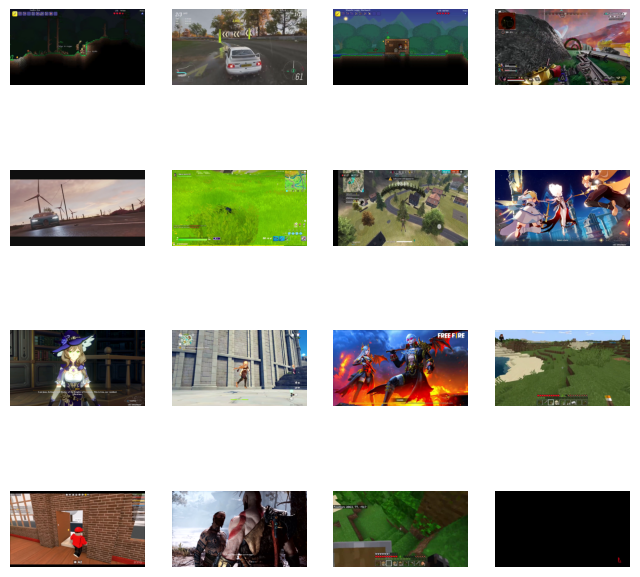

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def show_samples(image_paths, n=9):
    idx = np.random.choice(len(image_paths), n, replace=False)
    plt.figure(figsize=(8, 8))
    for i, i_img in enumerate(idx):
        image_path=image_paths[i_img]
        img = np.array(Image.open(image_path).convert("RGB"))
        plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), i + 1)
        plt.imshow(img.astype("uint8"))
        plt.axis("off")
    plt.show()

# Example usage
show_samples(file_paths,16)

## Separación de entrenamiento y de prueba
Para separar datos para el entranamiento del modelo y de prueba se puede utilizar la herramienta split de sklearn.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, metadata_train, metadata_test = train_test_split(
file_paths, games, test_size=0.3, random_state=42)

In [ ]:
print(len(X_train))
for path,game in zip(X_train,metadata_train):
    print(path,game)

7000
Dataset/Forza Horizon/image_787.png Forza Horizon
Dataset/Apex Legends/image_409.png Apex Legends
Dataset/Roblox/image_523.png Roblox
Dataset/Terraria/image_344.png Terraria
Dataset/Among Us/image_489.png Among Us
Dataset/Among Us/image_910.png Among Us
Dataset/God of War/image_602.png God of War
Dataset/Fortnite/image_832.png Fortnite
Dataset/Minecraft/image_1065.png Minecraft
Dataset/Genshin Impact/image_356.png Genshin Impact
Dataset/Among Us/image_582.png Among Us
Dataset/Among Us/image_540.png Among Us
Dataset/God of War/image_942.png God of War
Dataset/Apex Legends/image_563.png Apex Legends
Dataset/Fortnite/image_913.png Fortnite
Dataset/Terraria/image_708.png Terraria
Dataset/Minecraft/image_457.png Minecraft
Dataset/Forza Horizon/image_939.png Forza Horizon
Dataset/Terraria/image_117.png Terraria
Dataset/Genshin Impact/image_964.png Genshin Impact
Dataset/Fortnite/image_532.png Fortnite
Dataset/Among Us/image_359.png Among Us
Dataset/Minecraft/image_435.png Minecraft
Data

## Embedding
Las imágenes por sí solas, a pesar de que son significativas para un humano, no pueden ser utilizadas para entrenamiento. El análisis pixel a pixel no es efectivo para el aprendizaje, por lo que se utilizan técnicas como el **embedding**: pasar la imagen por un modelo especializado capaz de extraer información vectorial de la imagen que podrá ser utilizada para entrenar.

In [ ]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch, os


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model=model.to(device)
device


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

'cuda'

In [ ]:
def get_embedding(path):
    img = Image.open(path).convert("RGB")
    inputs = processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        emb = model.get_image_features(**inputs)
    return emb.cpu().squeeze().numpy()

In [ ]:
import numpy as np

embeddings_train=[get_embedding(path) for path in X_train]
embeddings_train=np.stack(embeddings_train)

## Entrenar modelo
Para entrenar un modelo existen diferentes algoritmos a utilizar, adaptados a diferentes finalidades. En este caso, como algoritmo alternativo, se utilizará Agglomerative Clustering. Su argumento de entrada es la cantidad de clusters a formar, similar a KMeans.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

agglomerative = AgglomerativeClustering(n_clusters=10)
labels = agglomerative.fit_predict(embeddings_train)

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


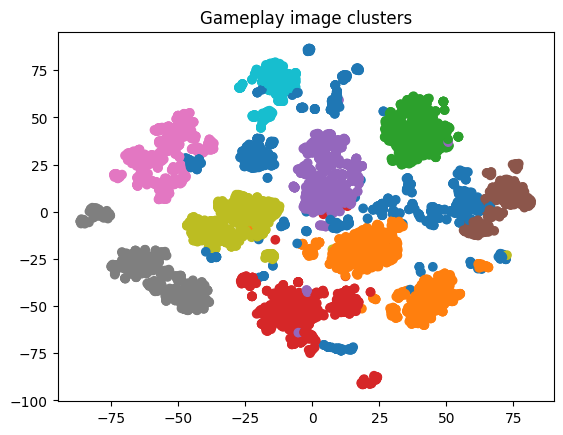

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

proj = TSNE(n_components=2, random_state=482).fit_transform(embeddings_train)
plt.scatter(proj[:, 0], proj[:, 1], c=labels, cmap="tab10")
plt.title("Gameplay image clusters")
plt.show()

In [ ]:
for cluster in range(number_of_games):
    print(f"Cluster {cluster}:")
    for f, lbl,real in zip(X_train,labels,metadata_train):
        if lbl == cluster:
            print(" ", f, " real: ", real)

Cluster 0:
  Dataset/Among Us/image_582.png  real:  Among Us
  Dataset/Among Us/image_359.png  real:  Among Us
  Dataset/Forza Horizon/image_891.png  real:  Forza Horizon
  Dataset/Among Us/image_289.png  real:  Among Us
  Dataset/Forza Horizon/image_614.png  real:  Forza Horizon
  Dataset/Apex Legends/image_186.png  real:  Apex Legends
  Dataset/Among Us/image_682.png  real:  Among Us
  Dataset/Forza Horizon/image_960.png  real:  Forza Horizon
  Dataset/Terraria/image_653.png  real:  Terraria
  Dataset/Apex Legends/image_65.png  real:  Apex Legends
  Dataset/Forza Horizon/image_201.png  real:  Forza Horizon
  Dataset/Free Fire/image_546.png  real:  Free Fire
  Dataset/Among Us/image_146.png  real:  Among Us
  Dataset/Forza Horizon/image_340.png  real:  Forza Horizon
  Dataset/Among Us/image_616.png  real:  Among Us
  Dataset/Forza Horizon/image_692.png  real:  Forza Horizon
  Dataset/Apex Legends/image_994.png  real:  Apex Legends
  Dataset/Forza Horizon/image_449.png  real:  Forza Ho

In [ ]:
import numpy as np

embeddings_test=[get_embedding(path) for path in X_test]
embeddings_test=np.stack(embeddings_test)

# Cambios en la comprobación
A diferencia del modelo KMeans utilizado en el ejemplo anterior, Agglomeration no está diseñado para "predecir" sobre nuevos datos que se le entreguen. Por lo tanto, es necesario utilizar KNN para predecir nuevos resultados a partir de los obtenidos con Agglomeration.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(embeddings_train, labels)

# Step 3: Predict clusters for new data
labels_test=knn.predict(embeddings_test)

In [ ]:
for cluster in range(number_of_games):
    print(f"Cluster {cluster}:")
    for f, lbl,real in zip(X_test,labels_test,metadata_test):
        if lbl == cluster:
            print(" ", f, " real: ", real)

Cluster 0:
  Dataset/Genshin Impact/image_294.png  real:  Genshin Impact
  Dataset/Among Us/image_450.png  real:  Among Us
  Dataset/Among Us/image_826.png  real:  Among Us
  Dataset/Apex Legends/image_11.png  real:  Apex Legends
  Dataset/Forza Horizon/image_962.png  real:  Forza Horizon
  Dataset/Terraria/image_257.png  real:  Terraria
  Dataset/Free Fire/image_5.png  real:  Free Fire
  Dataset/Apex Legends/image_1003.png  real:  Apex Legends
  Dataset/Among Us/image_310.png  real:  Among Us
  Dataset/Fortnite/image_181.png  real:  Fortnite
  Dataset/Among Us/image_222.png  real:  Among Us
  Dataset/Forza Horizon/image_341.png  real:  Forza Horizon
  Dataset/Apex Legends/image_155.png  real:  Apex Legends
  Dataset/Forza Horizon/image_889.png  real:  Forza Horizon
  Dataset/Forza Horizon/image_418.png  real:  Forza Horizon
  Dataset/God of War/image_226.png  real:  God of War
  Dataset/Free Fire/image_507.png  real:  Free Fire
  Dataset/Apex Legends/image_12.png  real:  Apex Legends


In [ ]:
import joblib
joblib.dump(agglomerative, "kmeans_model.pkl")

In [ ]:
import joblib
agglomerative = joblib.load("kmeans_modelf.pkl")